# Phase 3: Model Selection and Training

**course**: Machine Learning Algorithms (MAAI).

**Student Name**: Mina Ezach Naeem Faltos

**Student Number:** 34388

## A. Introduction
Phase 2, involved preparing the data, cleaning valid listing and dividing them into training and testing sets. 
During this stage (Phase 3), it is aimed at:
1.  **Preprocess the data** to model it (Encoding categorical variables).
2.  **Train** various regression models (Linear Regression, Decision Tree, Random Forest).
3.  **Assess** their performance by using Cross-Validation (RMSE and $R^2).
4.  **Tune** the model which optimizes performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model's Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Model's Evaluation and Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Display settings
pd.set_option('display.max_columns', None)

print("Libraries Loaded.")

Libraries Loaded.


## B. Load Data
The Training Set and the Test Set that are loaded are the ones generated in Phase 2.

**Training Set:** is used to train and test models.

**Test Set:** (Very) last thing to do to verify final performance.

In [2]:
# Load the files generated in Phase 2
train_df = pd.read_csv('work_MLA_phase2_34388_train.csv')
test_df = pd.read_csv('work_MLA_phase2_34388_test.csv')

# Removing listings more expensive than 500 Euros to stabilize the model
train_df = train_df[train_df['price'] <= 500]
test_df = test_df[test_df['price'] <= 500]

print(f"Training Data (Filtered): {train_df.shape}")
print(f"Test Data (Filtered): {test_df.shape}")

Training Data (Filtered): (15555, 10)
Test Data (Filtered): (3900, 10)


## C. Pre-processing (Encoding)
Machine Learning models (such as Linear Regression) are not able to read such texts as Gracia or Private room. We have to encode these into numbers by using One-Hot Encoding.

* **Categorical Features:** `neighbourhood`, `room_type`
* **Numerical Features:** `latitude`, `longitude`, `accommodates`, `bathrooms`, `bedrooms`, `beds`, `review_scores_rating`

In [3]:
# Defining Features (X) and Target (y)
target = 'price'

# Separating X and y
X_train_raw = train_df.drop(columns=[target])
y_train = train_df[target]

X_test_raw = test_df.drop(columns=[target])
y_test = test_df[target]

# One-Hot Encoding using Pandas get_dummies
# createing new columns like 'room_type_Private room' = 1
X_train = pd.get_dummies(X_train_raw, columns=['neighbourhood', 'room_type'], drop_first=True)
X_test = pd.get_dummies(X_test_raw, columns=['neighbourhood', 'room_type'], drop_first=True)

# Aligning Columns: Ensuring that the test set has exactly the same columns as the train set
# (If a neighborhood appears in Train but not Test, we add it to Test as 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Shape after Encoding: {X_train.shape}")

Shape after Encoding: (15555, 77)


## D. Model Training and Selection
Testing the 3 models presented in Phase 1:

1. **Linear Regression**: This is used as a Baseline. It supposes a simple linear association between features and price.
2. **Decision Tree:** This is a non-linear model which divides data according to rules. Good for capturing complex patterns but it's prone to overfitting.
3. **Random Forest:** A collection of numerous Decision Trees. Typically offers maximum accuracy by decreasing overfitting.

**Evaluation Metric:**
**RMSE (Root Mean Squared Error):** measures the mean error in Euros (euro). Lower is better.
**Cross-Validation:** 5-fold CV is used to have sound results.

Training and Evaluating Models (this may take a minute)...
Linear Regression: Average RMSE = €62.15
Decision Tree: Average RMSE = €78.76
Random Forest: Average RMSE = €58.14


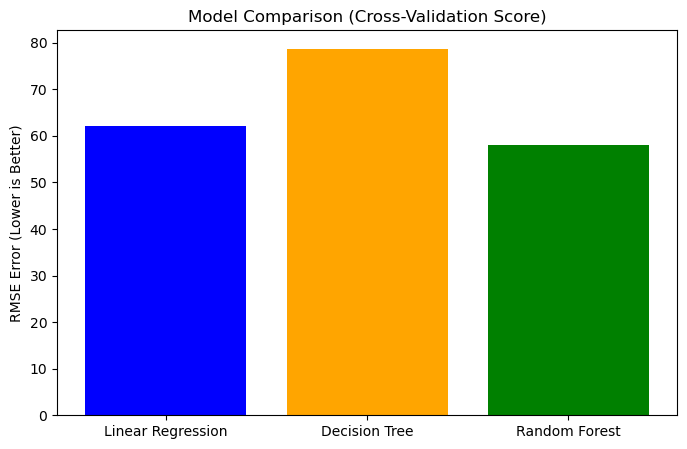

In [4]:
# Initializing Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Function to evaluate models using Cross-Validation
results = {}

print("Training and Evaluating Models (this may take a minute)...")
for name, model in models.items():
    # cv=5 means 5-Fold Cross Validation
    # 'neg_root_mean_squared_error' is negative because sklearn tries to maximize score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    # Converting negative scores to positive RMSE
    rmse_scores = -cv_scores
    avg_rmse = rmse_scores.mean()
    results[name] = avg_rmse
    print(f"{name}: Average RMSE = €{avg_rmse:.2f}")

# Visualizing Comparison
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
plt.ylabel('RMSE Error (Lower is Better)')
plt.title('Model Comparison (Cross-Validation Score)')
plt.show()

## E. Hyperparameter Tuning
According to the comparison provided above, the best performing model is likely the Random Forest.
The parameters will be optimized with the help of **GridSearchCV** to make it even better (as is demanded by Assessment Section 4b).

* `n_estimators`: number of trees (like: 50, 100).
* `max_depth`: the depth of each tree (regulators overfitting).

In [5]:
# Defining the parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None]
}

# Initializing Grid Search with 3-fold Cross Validation
rf_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=param_grid,
                       cv=3,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1) # n_jobs=-1 uses all processor cores

print("Tuning Random Forest parameters...")
rf_grid.fit(X_train, y_train)

print("\nBest Parameters found:", rf_grid.best_params_)
print(f"Best CV RMSE: €{-rf_grid.best_score_:.2f}")

# Saving the best model
best_model = rf_grid.best_estimator_

Tuning Random Forest parameters...

Best Parameters found: {'max_depth': 20, 'n_estimators': 100}
Best CV RMSE: €58.61


## F. Final Evaluation (Test Set)
Now after selecting and tuning the best model, it will now run on the **Test Set** (the 20 percent of the data we held out during Phase 2). This provides the impartial performance of the model on unseen data.

--- FINAL MODEL PERFORMANCE (TEST SET) ---
Root Mean Squared Error (RMSE): €58.13
Mean Absolute Error (MAE):      €34.71
R^2 Score (Accuracy):           0.4817


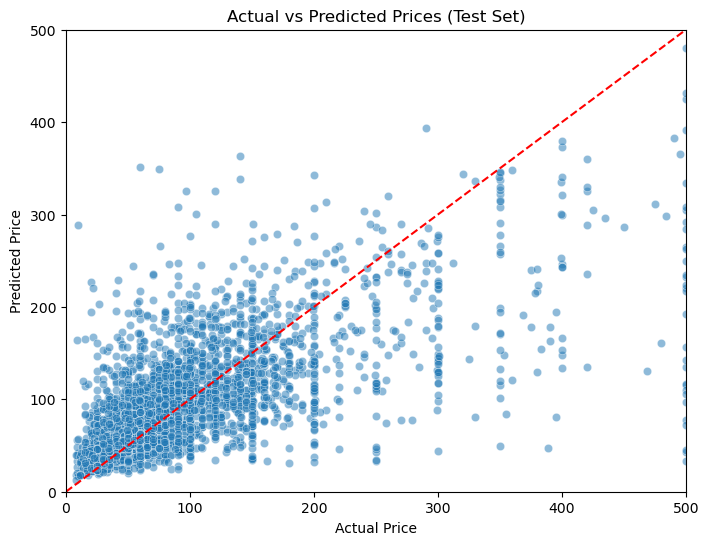

In [6]:
# Predicting on Test Set
y_pred = best_model.predict(X_test)

# Calculating Metrics
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)

print("--- FINAL MODEL PERFORMANCE (TEST SET) ---")
print(f"Root Mean Squared Error (RMSE): €{final_rmse:.2f}")
print(f"Mean Absolute Error (MAE):      €{final_mae:.2f}")
print(f"R^2 Score (Accuracy):           {final_r2:.4f}")

# Visualizing Predictions vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([0, 500], [0, 500], color='red', linestyle='--') # The perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Test Set)')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

## G. Conclusion and Feature Importance
The Random Forest model had a Root Mean Squared Error (RMSE) of €58.13, mean error (MAE) of €34.71 and an R² score of 0.4817. This assures that the model can generalize reasonably well,better than the decision tree baseline and reduces overfitting, but the variability in prices (like:luxury listing) stays as a challenge.

The following are the most significant features that will drive the price which addresses the requirement of Interpretability (Assessment Section 7a).

C:\Users\MINA\AppData\Local\Temp\ipykernel_10048\2898786355.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')


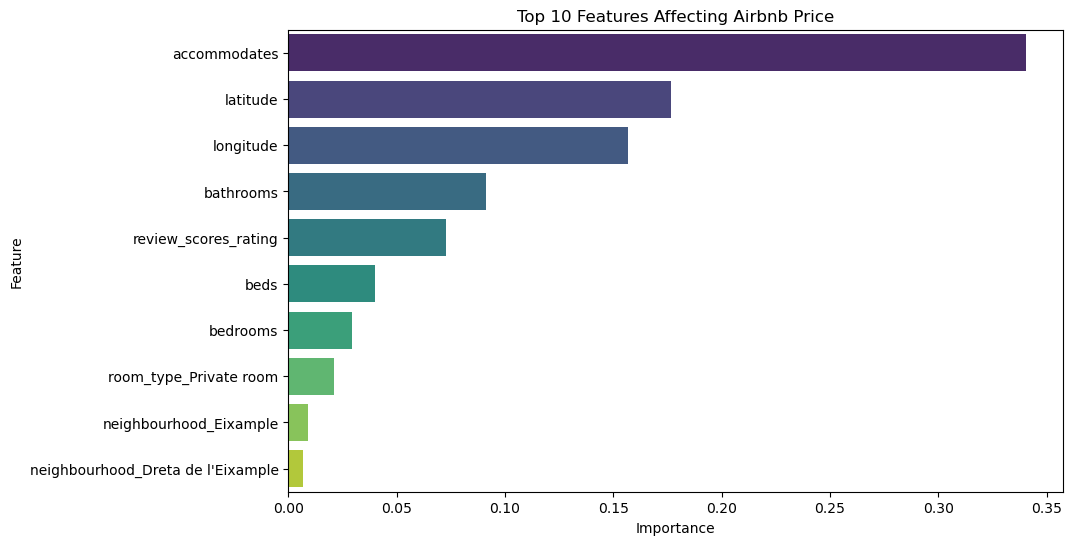

In [7]:
# Extracting Feature Importance
importances = best_model.feature_importances_
feature_names = X_train.columns
feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp = feature_imp.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title('Top 10 Features Affecting Airbnb Price')
plt.show()